In [1]:
#시각화 한글 보여주기 -> 설치하고 런타임 재시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rfz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (7,319 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 156210 files and d

In [2]:
import pandas as pd
import numpy as np

import os
import sys

# librosa 불러오기(파이썬 음성 분석 라이브러리) -> 음성시각화 및 벡터화 지원
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# 오디오파일 재생 라이브러리
from IPython.display import Audio

#케라스 불러오기
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

#오류무시
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
from google.colab import drive #코랩과 연결
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#감성대화 음성데이터 압축풀기
!unzip -qq "/content/drive/MyDrive/Colab Notebooks/감성대화/원천데이터/감성대화말뭉치(원천데이터)_음성데이터.zip"

In [14]:
#감성대화 라벨데이터 불러오기
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/감성대화/감성대화말뭉치_table.xlsx')
data_w = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/감성대화/감성대화말뭉치_w_table.xlsx')
#감정 및 음성데이터경로만 뽑아오기
data2 = data.loc[:,['감정_대분류','NO.']]
data2.columns = ['Emotions','Path']

data2_w = data_w.loc[:,['감정_대분류','NO.']]
data2_w.columns = ['Emotions','Path']

# 음성데이터 경로수정해주기(압축푼 폴더로)
## 남자 성우만 이용하도록 돼 있음!!!!!!!!!!!!!!11111
data2['Path'] = '/content/감성대화말뭉치AI데이터_Wave_남자성우_5000/'+data2['Path']+'.wav'
data2_w['Path'] = '/content/감성대화말뭉치AI데이터_Wave_여자성우_5000/'+data2_w['Path']+'.wav'

new_data = pd.concat([data2, data2_w])

#당황, 불안 빼는 건 다운샘플링 이후에 뺌
data_new = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/감성대화/KESDy18_csv.csv', index_col = 0)

data3 = pd.concat([new_data, data_new])
data3.tail(100)
#data_path.to_csv('/content/drive/MyDrive/Colab Notebooks/감성대화/all.csv')

,Emotions,Path
2780,분노,/content//drive/MyDrive/Colab Notebooks/감성...
2781,중립,/content//drive/MyDrive/Colab Notebooks/감성...
2782,분노,/content//drive/MyDrive/Colab Notebooks/감성...
2783,분노,/content//drive/MyDrive/Colab Notebooks/감성...
2784,분노,/content//drive/MyDrive/Colab Notebooks/감성...
...,...,...
2875,기쁨,/content//drive/MyDrive/Colab Notebooks/감성...
2876,중립,/content//drive/MyDrive/Colab Notebooks/감성...
2877,기쁨,/content//drive/MyDrive/Colab Notebooks/감성...
2878,중립,/content//drive/MyDrive/Colab Notebooks/감성...


In [15]:
A, B = data3.iloc[:,:-1], data3.iloc[:,-1].values
B=B.reshape(-1, 1)

In [16]:
B

array([['/content/감성대화말뭉치AI데이터_Wave_남자성우_5000/M_000001.wav'],
       ['/content/감성대화말뭉치AI데이터_Wave_남자성우_5000/M_000002.wav'],
       ['/content/감성대화말뭉치AI데이터_Wave_남자성우_5000/M_000003.wav'],
       ...,
       ['/content//drive/MyDrive/Colab Notebooks/감성대화/KESDy18/wav/030_dy_h_15.wav'],
       ['/content//drive/MyDrive/Colab Notebooks/감성대화/KESDy18/wav/030_dy_n_15.wav'],
       ['/content//drive/MyDrive/Colab Notebooks/감성대화/KESDy18/wav/030_dy_s_02.wav']],
      dtype=object)

In [17]:
from imblearn.under_sampling import RandomUnderSampler
B_resampled, A_resampled = RandomUnderSampler(random_state=0).fit_resample(B, A)

In [18]:
data4 = pd.DataFrame(columns=['Emotions', 'Path'])

In [19]:
data4['Emotions'], data4['Path'] = pd.DataFrame(A_resampled), pd.DataFrame(B_resampled)

In [20]:
# 감정데이터중에 '당황'라벨 제거해주기
## 불안도 빼기__________________________________________________________
data_path = data4[data4['Emotions']!='당황']
data_path = data_path[data_path['Emotions']!='불안']

In [21]:
data_path['Emotions'].value_counts()

기쁨    720
분노    720
상처    720
슬픔    720
중립    720
Name: Emotions, dtype: int64

In [22]:
data_path.dropna()

,Emotions,Path
0,기쁨,/content//drive/MyDrive/Colab Notebooks/감성...
1,기쁨,/content/감성대화말뭉치AI데이터_Wave_남자성우_5000/M_001429.wav
2,기쁨,/content//drive/MyDrive/Colab Notebooks/감성...
3,기쁨,/content/감성대화말뭉치AI데이터_Wave_여자성우_5000/F_004868.wav
4,기쁨,/content/감성대화말뭉치AI데이터_Wave_남자성우_5000/M_002499.wav
...,...,...
5035,중립,/content//drive/MyDrive/Colab Notebooks/감성...
5036,중립,/content//drive/MyDrive/Colab Notebooks/감성...
5037,중립,/content//drive/MyDrive/Colab Notebooks/감성...
5038,중립,/content//drive/MyDrive/Colab Notebooks/감성...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
findfont: Font family ['SangSangTitleB'] not found. Falling back to DejaVu Sans.
findfont: Font family ['SangSangTitleB'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49256 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/lo

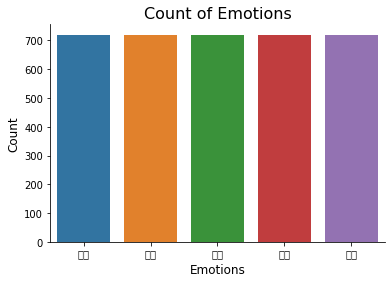

In [23]:
# 도표 및 그림에서 한글사용하기
plt.rc('font', family='SangSangTitleB') 

# 감정의 전체적인 분포 확인하기
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [24]:
# 음성데이터를 waveplot, spectrogram 이미지로 표현

def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft 함수는 음성을 시간기반에서 주파수기반으로 변환함
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

findfont: Font family ['SangSangTitleB'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49836 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 54548 missing from current font.
  font.set_text(s, 0, flags=flags)


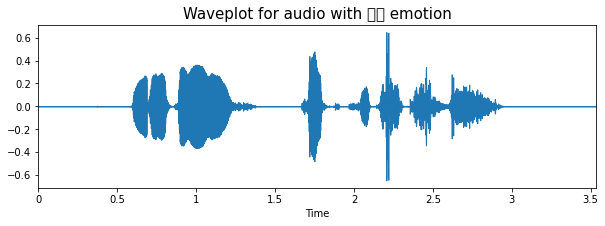

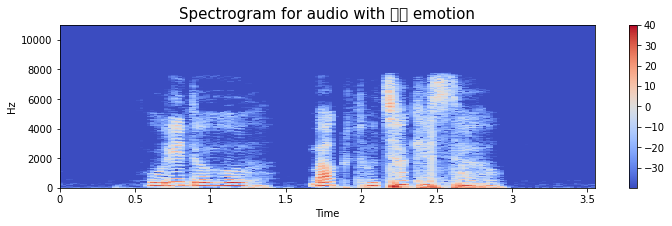

In [25]:
#슬픔 음성데이터 예시로 보기
emotion='슬픔'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [26]:
# 음성데이터 argumentation을 통해서 데이터 수 늘리기 및 오버피팅 방지
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    ## np.random.uniform() 모수 설정해주는 함수
    ## np.amax data의 최댓값을 반환함
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
    ## rate 만큼 늘려줌, 빠르기 조절

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    ## shift_range 밀어주는 정도
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)
    ## 파형 피치 조정

# 예시
## 위에서 지정해줌
#$path = np.array(data_path.Path)[1]
#data, sample_rate = librosa.load(path)


# 음성의 특성추출하는 함수 ( MFCC, MEL, RMSV)
# spectrum으로 변환
def extract_features(data):

    result = np.array([])

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    #rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    #result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sampling_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

# 음성의 특성을 추출한 데이터를 축적하는 함수 (Argumentation된 데이터도 같이)
def get_features(path):
    # duration과 offset은 각 오디오 파일의 시작과 끝에서 오디오가 없는 것을 처리
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # 원래데이터
    res1 = extract_features(data)
    result = np.array(res1)
    # 노이즈가 추가된 데이터
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # 병렬적으로 추가

    # 피칭및 스트레칭된 데이터
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # 병렬적으로 추가

    return result

In [27]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        ## ele : spectrum
        # 2개의 augmentation이 존재하므로 총 한개의 음성데이터가 3개의 음성데이터가 됨
        Y.append(emotion)

In [28]:
len(X), len(Y), data_path.Path.shape

(10800, 10800, (3600,))

In [29]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,139,140,141,142,143,144,145,146,147,labels
0,-385.802826,74.665573,-26.405066,20.539738,-13.504493,-3.440406,-2.900476,-1.838419,1.027405,1.675209,...,0.000011,0.000010,0.000009,0.000009,0.000008,0.000008,0.000007,0.000007,0.000007,기쁨
1,-325.557970,57.982230,-20.485712,11.602726,-10.074788,-9.342476,-3.477494,-4.183131,0.861686,0.566897,...,0.000099,0.000099,0.000107,0.000109,0.000111,0.000107,0.000112,0.000106,0.000109,기쁨
2,-445.031677,82.166649,-30.963327,20.599276,-19.410862,-4.865939,-5.008787,-0.943829,0.267913,2.132282,...,0.000013,0.000012,0.000011,0.000011,0.000010,0.000011,0.000016,0.000031,0.000043,기쁨
3,-255.107590,88.834412,-17.320568,3.130002,-2.488511,-14.675508,-12.655499,-2.733911,-27.504713,-2.243372,...,0.003367,0.004787,0.003507,0.004611,0.002727,0.002680,0.002271,0.000607,0.000041,기쁨
4,-180.253682,51.357933,-2.518514,-1.426699,-2.496199,-10.188173,-7.791156,-7.342913,-15.336154,-5.511380,...,0.007556,0.008699,0.007953,0.009037,0.007053,0.007032,0.006941,0.004874,0.004257,기쁨


In [30]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [31]:
# 다중 클래스 분류하기위해 Y설정
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [32]:
# 훈련데이터, 테스트데이터 분리
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, stratify= Y, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8100, 148), (8100, 5), (2700, 148), (2700, 5))

In [33]:
# 훈련 및 테스트데이터 갯수 확인
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8100, 148), (8100, 5), (2700, 148), (2700, 5))

In [34]:
# 데이터의 차원 모델에 맞게 통일 
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8100, 148, 1), (8100, 5), (2700, 148, 1), (2700, 5))

**모델2 다운샘플링 + stratify =y + dropout = 0.3**

In [41]:
model2=Sequential()
model2.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model2.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model2.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model2.add(Dropout(0.2))

model2.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model2.add(Flatten())
model2.add(Dense(units=32, activation='relu'))
model2.add(Dropout(0.3))

model2.add(Dense(units=5, activation='softmax'))
###6_______________
model2.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 148, 256)          1536      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 74, 256)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 74, 256)           327936    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 37, 256)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 37, 128)           163968    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 19, 128)         

In [42]:
#모델2 훈련
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.5, verbose=0, patience=3, min_lr=0.000005)
#monitor : 기준으로 삼을 값, factor : learning rate를 얼마나 감소시킬지 정하는 인자값, patience : 모니터되는 값의 개선이 없을 경우 얼마나 더 작동시키고 learning rate를 감소 적용할지, verbose : 화면 표기 없이 걍 종료
history2 = model2.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp]) #배치 사이즈가 작다
#65번째 learning rate가 조절된 이후 test 입장에서 학습 결과가 더 안 좋아진다
from keras.models import load_model
model2.save('ser_model.h5')

Epoch 1/100
127/127 [==============================] - 3s 13ms/step - loss: 1.5304 - accuracy: 0.2938 - val_loss: 1.4454 - val_accuracy: 0.3696 - lr: 0.0010
Epoch 2/100
127/127 [==============================] - 1s 9ms/step - loss: 1.4044 - accuracy: 0.3701 - val_loss: 1.3170 - val_accuracy: 0.4137 - lr: 0.0010
Epoch 3/100
127/127 [==============================] - 1s 9ms/step - loss: 1.3073 - accuracy: 0.4114 - val_loss: 1.2369 - val_accuracy: 0.4381 - lr: 0.0010
Epoch 4/100
127/127 [==============================] - 1s 11ms/step - loss: 1.2569 - accuracy: 0.4372 - val_loss: 1.2052 - val_accuracy: 0.4411 - lr: 0.0010
Epoch 5/100
127/127 [==============================] - 1s 9ms/step - loss: 1.2258 - accuracy: 0.4530 - val_loss: 1.1803 - val_accuracy: 0.4678 - lr: 0.0010
Epoch 6/100
127/127 [==============================] - 1s 11ms/step - loss: 1.1917 - accuracy: 0.4716 - val_loss: 1.1845 - val_accuracy: 0.4693 - lr: 0.0010
Epoch 7/100
127/127 [==============================] - 1s 10m

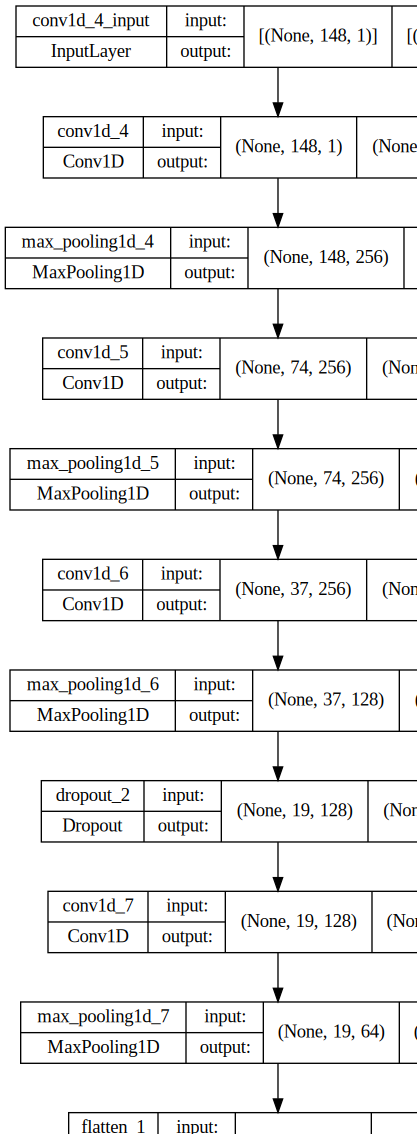

In [43]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
 
%matplotlib inline
 
SVG(model_to_dot(model2, show_shapes=True).create(prog='dot', format='svg'))

콜백함수가 필요한 이유: 모델이 학습을 시작하면 학습이 완료될 때까지 사람이 할 수 있는게 없습니다. 따라서 이를 해결하고자 존재하는 것이 콜백함수입니다. 예를 들어, 학습되는 과정 사이에 학습률을 변화시키거나 val_loss가 개선되지 않으면 학습을 멈추게 하는 등의 작업을 할 수 있습니다.

출처: https://deep-deep-deep.tistory.com/1 [딥딥딥]

85/85 [==============================] - 0s 4ms/step - loss: 1.6532 - accuracy: 0.7259
Accuracy of our model on test data :  72.59259223937988 %


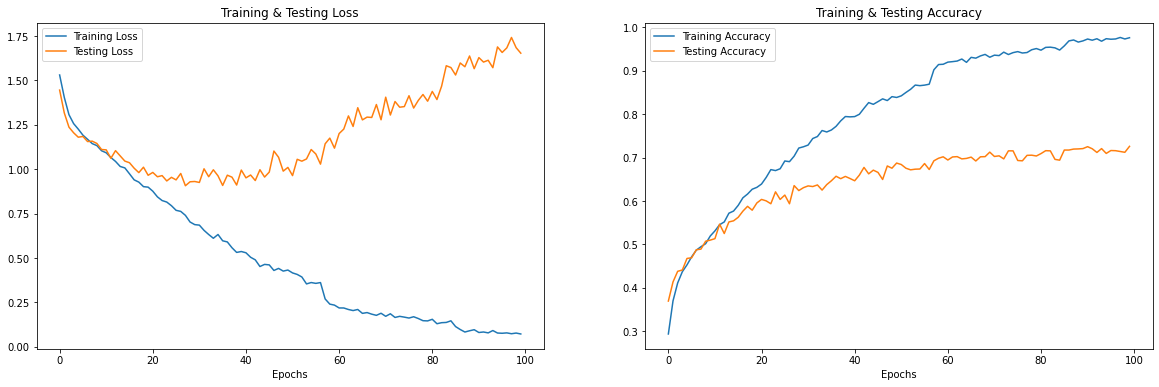

In [44]:
#모델2 그래프
print("Accuracy of our model on test data : " , model2.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig2 , ax2 = plt.subplots(1,2)
train_acc2 = history2.history['accuracy']
train_loss2 = history2.history['loss']
test_acc2 = history2.history['val_accuracy']
test_loss2 = history2.history['val_loss']

fig2.set_size_inches(20,6)
ax2[0].plot(epochs , train_loss2 , label = 'Training Loss')
ax2[0].plot(epochs , test_loss2 , label = 'Testing Loss')
ax2[0].set_title('Training & Testing Loss')
ax2[0].legend()
ax2[0].set_xlabel("Epochs")

ax2[1].plot(epochs , train_acc2 , label = 'Training Accuracy')
ax2[1].plot(epochs , test_acc2 , label = 'Testing Accuracy')
ax2[1].set_title('Training & Testing Accuracy')
ax2[1].legend()
ax2[1].set_xlabel("Epochs")
plt.show()

아직 loss는 계속 떨어지는 추세 입니다. 이럴 경우 모델이 아직 saturation이 안되었다고 말합니다. 모델이 잘 만들어졌고, 데이터도 적절하다면 훈련을 지속했을때 train set loss와 validation set loss가 같이 떨어지다가, 어느 순간 validation set loss가 상승하는 경우를 볼 수 있습니다. 일반적으로 그 지점에서 훈련을 중단합니다. 그 전에 훈련을 멈추면, 언더피팅인 상태고, 훈련을 더 계속하면 오버피팅 상태로 보는 것이죠. 이런 방식으로 훈련의 시간을 정하는 방식을 Early Stopping이라고도 부릅니다.

- precision : 정밀도
- Recall : 재현율, 실제 양성 클래스에 속한 샘플 중 양성 클래스라고 예측한 샘플 수의 비율
- Accuracy : 정확도
- F1-score : 가중 조화평균??
- support : 각 라벨의 실제 샘플 개수
- macro avg : 단순 평균
- weighted avg : 가중 평균(샘플 개수의 불균형 고려)

#와우.... 일단 해보십시다

In [45]:
!pip install moviepy
!pip install pydub

In [46]:
import os
import librosa
import numpy as np
import librosa
import librosa.display
import IPython.display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
from pydub import AudioSegment
import wave
import soundfile as sf
import moviepy.editor as mp

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2400256/45929032 bytes (5.2%)5799936/45929032 bytes (12.6%)9084928/45929032 bytes (19.8%)11714560/45929032 bytes (25.5%)14508032/45929032 bytes (31.6%)17113088/45929032 bytes (37.3%)20209664/45929032 bytes (44.0%)23781376/45929032 bytes (51.8%)27426816/45929032 bytes (59.7%)31039488/45929032 bytes (67.6%)34480128/45929032 bytes (75.1%)37838848/45929032 bytes (82.4%)

In [175]:
mp4_save = "/content/drive/MyDrive/Colab Notebooks/감성대화/videos/"
mp4_list = os.listdir(mp4_save)
print(mp4_list)
for mp4_name in mp4_list:
  if mp4_name.find('mp4') is not -1:
    name = mp4_name[:-4]
    print(name)

['Bus_in_Rock_Tunnel.webm', 'Eiffel Tower.mp4', 'Statue of Liberty.mp4', 'Bike Polo.mp4', 'Excavators river crossing.mp4', 'playing_ball.mp4', 'Uncut_Evening_Flight.mp4', 'Kids_playing_in_leaves.mp4', 'Bearpark_climbing.mp4', 'Cooking.mp4', 'Fire Domino.mp4', 'Valparaiso_Downhill.mp4', 'Saving dolphines.mp4', 'Jumps.mp4', 'Cockpit_Landing.mp4', 'paluma_jump.mp4', 'Base jumping.mp4', 'Car_railcrossing.mp4', 'Air_Force_One.mp4', 'Playing_on_water_slide.mp4', 'car_over_camera.mp4', 'Notre_Dame.mp4', 'Paintball.mp4']
Eiffel Tower
Statue of Liberty
Bike Polo
Excavators river crossing
playing_ball
Uncut_Evening_Flight
Kids_playing_in_leaves
Bearpark_climbing
Cooking
Fire Domino
Valparaiso_Downhill
Saving dolphines
Jumps
Cockpit_Landing
paluma_jump
Base jumping
Car_railcrossing
Air_Force_One
Playing_on_water_slide
car_over_camera
Notre_Dame
Paintball


In [177]:
mp4_save = "/content/drive/MyDrive/Colab Notebooks/감성대화/videos/"
mp4_list = os.listdir(mp4_save)

for mp4_name in mp4_list:
  if mp4_name.find('mp4') is not -1:
    name = mp4_name[:-4]
    a = "/content/drive/MyDrive/Colab Notebooks/감성대화/videos/" + name + ".mp4"
    clip = mp.VideoFileClip(a)
    clip.audio.write_audiofile("audio.mp3")

    src = "audio.mp3"
    dst = "test.wav"
    sound = AudioSegment.from_mp3(src) # load file as extention 'mp3' 
    sound.export(dst, format="wav") # convert file to wav

    import math

    sound2 = AudioSegment.from_mp3("test.wav")

    two_seconds = 1*1000

    for i in range(int(math.floor(len(sound2)/1000))):
      slice = sound2[i*two_seconds:two_seconds*(i+1)]
      slice.export(name+'_{}.wav'.format(i), format = "wav")

    import glob
    sound_path = glob.glob('/content/'+name+'*.wav')

    def gfs(path):
      # duration과 offset은 각 오디오 파일의 시작과 끝에서 오디오가 없는 것을 처리 (duration : 로드할 오디오 길이, offset : 앞뒤 이정도 자르기)
      data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
      # 원래데이터
      res1 = extract_features(data)
      result = np.array(res1)

      return result 

    Z = []
    for path in sound_path:
        feature = gfs(path)
        for ele in feature:
            Z.append(ele)
            # 2개의 augmentation이 존재하므로 총 한개의 음성데이터가 3개의 음성데이터가 됨 (stretch한거랑 noise 더한 것)

    Z = np.array(Z)
    a = str(Z.shape)
    a = a[1:-2]

    b = int(a) / 148
    W=Z.reshape(int(b),148)

    ExperimentFeatures = pd.DataFrame(W)
    ExperimentFeatures.to_csv(name+'.csv', index=False)
    ExperimentFeatures.shape

    EF = ExperimentFeatures.iloc[: ,:].values
    EF = scaler.transform(EF)

    EF = np.expand_dims(EF, axis=2)

    from keras.models import load_model
    model = load_model('ser_model.h5')

    pred_test = model.predict(EF)

    EF_pred = encoder.inverse_transform(pred_test)
    df = pd.DataFrame(columns=['Predicted Labels'])
    df['Predicted Labels'] = EF_pred.flatten()

    df.to_csv('/content/drive/MyDrive/Colab Notebooks/감성대화/'+name+'.csv', index=False)

[MoviePy] Writing audio in audio.mp3


100%|██████████| 4385/4385 [00:08<00:00, 538.01it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 3408/3408 [00:04<00:00, 773.21it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 2252/2252 [00:02<00:00, 999.45it/s] 

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 8574/8574 [00:09<00:00, 878.94it/s] 

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 2293/2293 [00:01<00:00, 1151.20it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 7116/7116 [00:08<00:00, 818.97it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 2345/2345 [00:03<00:00, 712.77it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 2947/2947 [00:04<00:00, 684.46it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 1892/1892 [00:02<00:00, 926.27it/s]


[MoviePy] Done.
[MoviePy] Writing audio in audio.mp3


100%|██████████| 1185/1185 [00:01<00:00, 737.49it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 3810/3810 [00:05<00:00, 759.90it/s] 

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 4917/4917 [00:06<00:00, 726.30it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 838/838 [00:00<00:00, 845.32it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 6656/6656 [00:06<00:00, 1016.74it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 1894/1894 [00:01<00:00, 1120.96it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 3480/3480 [00:05<00:00, 672.80it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 3734/3734 [00:03<00:00, 1053.04it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 3964/3964 [00:04<00:00, 984.24it/s] 

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 2256/2256 [00:01<00:00, 1158.56it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 3224/3224 [00:02<00:00, 1085.08it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 4234/4234 [00:06<00:00, 638.02it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio.mp3


100%|██████████| 5607/5607 [00:08<00:00, 633.72it/s]

[MoviePy] Done.
